Run this in a terminal to make sure the shared folder is mounted (only at the beginning when booting up the VM.)

    sudo mount -t vboxsf -o uid=$UID,gid=$(id -g) simulation_results ~/Documents/sf_simulation_results/

Then compile the Cartilage Sheet Simulation app using make.

In [1]:
%%bash
cd ../chaste_build/
make CartilageSheetSimulation

[  5%] Built target timekeeper
[ 15%] Built target chaste_global
[ 15%] Built target chaste_linalg
[ 21%] Built target chaste_io
[ 26%] Built target chaste_ode
[ 42%] Built target chaste_mesh
[ 47%] Built target chaste_pde
[ 94%] Built target chaste_cell_based
Scanning dependencies of target chaste_project_cartilage
[ 94%] Building CXX object projects/cartilage/CMakeFiles/chaste_project_cartilage.dir/src/NodeBasedCartilageSheet.cpp.o
[ 94%] Building CXX object projects/cartilage/CMakeFiles/chaste_project_cartilage.dir/src/cell/cycle/CellTissueTypeBasedCellCycleModel.cpp.o
[ 94%] Linking CXX shared library libchaste_project_cartilage.so
[100%] Built target chaste_project_cartilage
Scanning dependencies of target CartilageSheetSimulation
[100%] Building CXX object projects/cartilage/apps/CMakeFiles/CartilageSheetSimulation.dir/src/CartilageSheetSimulation.cpp.o
[100%] Linking CXX executable CartilageSheetSimulation
[100%] Built target CartilageSheetSimulation


Now run the simulation using (set the flags to correspond to your experimental setup)

In [2]:
import sys
sys.path.append('analysis')

import numpy as np
import time 
import matplotlib.pyplot as plt
import distribute_executable as de
import sheet_metrics as sm

plt.style.use('seaborn-whitegrid')
#plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         'font.size': 12}
plt.rcParams.update(params)

# Runs with perturbation of 0.1

Data archive (the first three have been run with a uniformly distributed cell cycle model, as well as perichondrial cells dividing every 24 hours):

- 10 random seeds (0--9) with mu_R = 12.0:
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-155233/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --p 0.1
- 10 random seeds (0--9) with mu_R = 120.0:
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200303-155128/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 120.0 --p 0.1
- 10 random seeds (0--9) with mu_R = 8.0:
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200303-163452/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 8.0 --p 0.1
- 10 random seeds (0--9) with mu_R = 8.0 (now with exponentially distributed cell cycle)
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-120054/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 8.0 --p 0.1

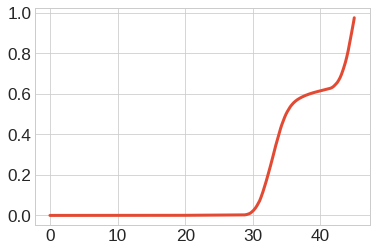

In [4]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
dir_mu12 = 'exp-effect_repulsion_and_orientation/20200226-155233/'
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu12 + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu12+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10

plt.plot(times, ppa_av)

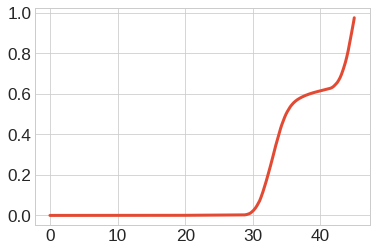

In [10]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
dir_mu120 = 'exp-effect_repulsion_and_orientation/20200303-155128/'
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu12 + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu12+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10

plt.plot(times, ppa_av)

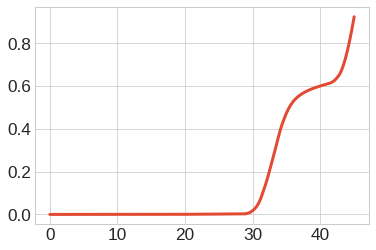

In [3]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
dir_mu8 = 'exp-effect_repulsion_and_orientation/20200303-163452/'
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu8 + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_mu8+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10

plt.plot(times, ppa_av)

Let's try out with an exponentially distributed cell cycle model and perichondrial cells only dividing at the beginning of the simulation.

In [16]:
output_directory = 'exp-effect_repulsion_and_orientation/' + time.strftime("%Y%m%d-%H%M%S") +'/'
flags = ' --sbt' # synchronized birth times
flags = flags + ' --T 45.0' # final time 45h
flags = flags + ' --sw 10' # 10 cells in x direction
flags = flags + ' --sd 20' # 20 cells in y direction
flags = flags + ' --sh 1' # 1 cell in z direction
flags = flags + ' --mu 0.0' # adhesive spring stiffness set to 0 -> repulsion only
flags = flags + ' --A 0.5' # 50% of stem cells activated
flags = flags + ' --F pwq' # PWQ force
flags = flags + ' --mu_R 80.0' # set repulsive spring stiffness to 80.0
flags = flags + ' --p 0.1' # set perturbation to 0.1




In [17]:
de.run_simulations_multiple_random_seeds(output_directory, flags=flags, number_of_simulations=10)

nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-144807/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-144807/ --S 1 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-144807/ --S 2 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-144807/ --S 3 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 

Note that the output from the bash subprocesses gets printed in the shell running the jupyter notebook server - check there for error messages!

Then run postprocessing. Note that the post processing currently assumes a simulation run time until at least T=45.0. And if there's no upper boundary it will encounter All-NaN slices and print out warnings.

In [7]:
de.run_postprocessing_multiple_random_seeds(10, output_directory)

['/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/0/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/1/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/2/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/3/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/4/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/5/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-120054/6/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311

analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN slice encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN axis encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN slice encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(coordinates[:,2::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN axis encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(c

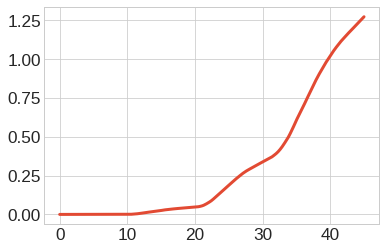

In [8]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10

plt.plot(times, ppa_av)

# Runs without perturbation of the initial coordinates

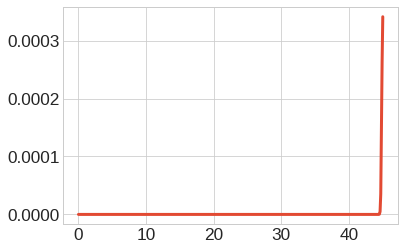

In [9]:
dir_no_perturbation = 'exp-effect_repulsion_and_orientation/20200226-150623'
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_no_perturbation + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_no_perturbation + str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10
plt.plot(times, ppa_av)

This is a numerical instability. Right now the columns will only be straight if there is no initial perturbation. However, biologically this does not make sense. Hence we should always run simulation with perturbation and try to get an handle of the numerical instability.

# Now let us run the random cell division direction case

I also think we could maybe use a lower activation percentage, but let's leave it consistent for now. (Simulations would be faster!)

Data archive:

- 10 random seeds (0--9) with mu_R = 12.0 and random cell division directions (uniform distribution + perichondrial cells divide every 24 hours):
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200226-161335/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 12.0 --rdd
- 10 random seeds (0--9) with mu_R = 8.0 and random cell division directions (exponential distribution + perichondrial cells divide every 60 hours):
        nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-130619/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 8.0 --p 0.1 --rdd

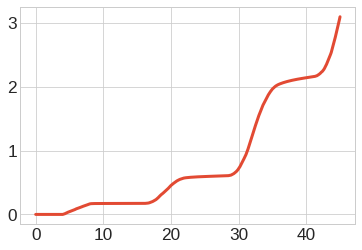

In [4]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
dir_rdd = 'exp-effect_repulsion_and_orientation/20200226-161335/'
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_rdd+ '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_rdd+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10
plt.plot(times, ppa_av)

In [18]:
output_directory = 'exp-effect_repulsion_and_orientation/' + time.strftime("%Y%m%d-%H%M%S") +'/'
flags = ' --sbt' # synchronized birth times
flags = flags + ' --T 45.0' # final time 45h
flags = flags + ' --sw 10' # 10 cells in x direction
flags = flags + ' --sd 20' # 20 cells in y direction
flags = flags + ' --sh 1' # 1 cell in z direction
flags = flags + ' --mu 0.0' # adhesive spring stiffness set to 0 -> repulsion only
flags = flags + ' --A 0.5' # 50% of stem cells activated
flags = flags + ' --F pwq' # PWQ force
flags = flags + ' --mu_R 80.0' # set repulsive spring stiffness to 80.0
flags = flags + ' --p 0.1' # set maximum perturbation of coordinates to 0.1
flags = flags + ' --rdd' # set random division directions


In [19]:
de.run_simulations_multiple_random_seeds(output_directory, flags=flags, number_of_simulations=10)

nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-145344/ --S 0 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-145344/ --S 1 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-145344/ --S 2 --sbt --T 45.0 --sw 10 --sd 20 --sh 1 --mu 0.0 --A 0.5 --F pwq --mu_R 80.0 --p 0.1 --rdd
nice -n 19 /home/kubuntu1804/Documents/chaste_build/projects/cartilage/apps/CartilageSheetSimulation --output-dir exp-effect_repulsion_and_orientation/20200311-145344/ --S 3 --sbt --T 45.0 --sw 10 --sd 20 --sh 1

In [20]:
de.run_postprocessing_multiple_random_seeds(10, output_directory)

['/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/0/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/1/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/2/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/3/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/4/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/5/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-145344/6/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311

analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN slice encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN axis encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN slice encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(coordinates[:,2::3], axis=1))
analysis/sheet_metrics.py:94: RuntimeWarning: All-NaN axis encountered
  width[:, 2] = abs(np.nanmax(coordinates[:,2::3], axis=1)- np.nanmin(c

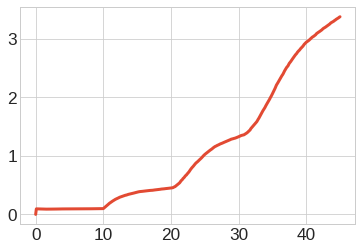

In [22]:
# time steps are consistent across runs, so it's sufficient to load them from a single path
times, coords = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory + '0/results_from_time_0/') 

ppa_av = np.zeros(times.shape)
for seed in range(10):
    ppa_av = ppa_av + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+output_directory+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av = ppa_av /10
plt.plot(times, ppa_av)

# Plot both random and directed cell division in single figure

Text(0,0.5,'Average patch projection area')

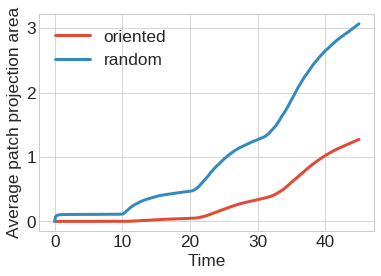

In [15]:
dir_directed = 'exp-effect_repulsion_and_orientation/20200311-120054/'
dir_random = 'exp-effect_repulsion_and_orientation/20200311-130619/'

# time steps are consistent across runs, so it's sufficient to load them from a single path
times_d, coords_d = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_directed + '0/results_from_time_0/') 

ppa_av_d = np.zeros(times.shape)
for seed in range(10):
    ppa_av_d = ppa_av_d + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_directed+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av_d = ppa_av_d /10

# time steps are consistent across runs, so it's sufficient to load them from a single path
times_r, coords_r = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_random + '0/results_from_time_0/') 

ppa_av_r = np.zeros(times.shape)
for seed in range(10):
    ppa_av_r = ppa_av_r + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_random+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av_r = ppa_av_r /10


plt.plot(times_d, ppa_av_d, label='oriented')
plt.plot(times_r, ppa_av_r, label='random')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Average patch projection area')


# 10 times larger mu

Text(0,0.5,'Average patch projection area')

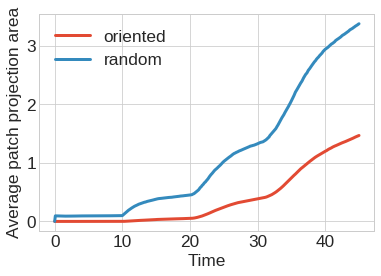

In [23]:
dir_directed = 'exp-effect_repulsion_and_orientation/20200311-144807/'
dir_random = 'exp-effect_repulsion_and_orientation/20200311-145344/'

# time steps are consistent across runs, so it's sufficient to load them from a single path
times_d, coords_d = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_directed + '0/results_from_time_0/') 

ppa_av_d = np.zeros(times.shape)
for seed in range(10):
    ppa_av_d = ppa_av_d + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_directed+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av_d = ppa_av_d /10

# time steps are consistent across runs, so it's sufficient to load them from a single path
times_r, coords_r = sm.read_in_data('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_random + '0/results_from_time_0/') 

ppa_av_r = np.zeros(times.shape)
for seed in range(10):
    ppa_av_r = ppa_av_r + np.loadtxt('/home/kubuntu1804/Documents/sf_simulation_results/'+dir_random+str(seed)+'/results_from_time_0/metrics_results/data_patch_projection_area_av.txt', dtype=float)
ppa_av_r = ppa_av_r /10


plt.plot(times_d, ppa_av_d, label='oriented')
plt.plot(times_r, ppa_av_r, label='random')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Average patch projection area')

In [21]:

de.run_postprocessing_multiple_random_seeds(10, 'exp-effect_repulsion_and_orientation/20200311-144807/')

['/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/0/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/1/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/2/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/3/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/4/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/5/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311-144807/6/results_from_time_0/', '/home/kubuntu1804/Documents/sf_simulation_results/exp-effect_repulsion_and_orientation/20200311

analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN slice encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:93: RuntimeWarning: All-NaN axis encountered
  width[:, 1] = abs(np.nanmax(coordinates[:,1::3], axis=1)- np.nanmin(coordinates[:,1::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN slice encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(coordinates[:,0::3], axis=1))
analysis/sheet_metrics.py:92: RuntimeWarning: All-NaN axis encountered
  width[:, 0] = abs(np.nanmax(coordinates[:,0::3], axis=1)- np.nanmin(c

You can generate a png visualizing clonal patches using

In [7]:
%%bash
pvpython analysis/paraview_show_clonal_patches.py -i /home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/

Input file path is /home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/


Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/Volume/vtkVolumeTextureMapper3D.cxx, line 680
vtkVolumeTextureMapper3D::vtkVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/VolumeOpenGL/vtkOpenGLVolumeTextureMapper3D.cxx, line 57
vtkOpenGLVolumeTextureMapper3D::vtkOpenGLVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/Volume/vtkVolumeTextureMapper3D.cxx, line 680
vtkVolumeTextureMapper3D::vtkVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed in a future version.

Generic Warning: In /build/paraview-lH8wFv/paraview-5.4.1+dfsg3/VTK/Rendering/VolumeOpenGL/vtkOpenGLVolumeTextureMapper3D.cxx, line 57
vtkOpenGLVolumeTextureMapper3D::vtkOpenGLVolumeTextureMapper3D was deprecated for VTK 7.0 and will be removed 

And render the png using

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

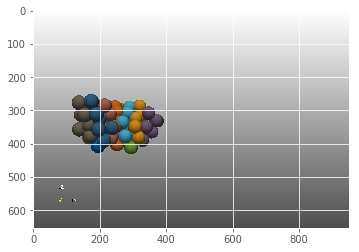

In [15]:
image = mpimg.imread("/home/kubuntu1804/Documents/sf_simulation_results/dev-setup_experiments/0/patches_t40.png")
plt.imshow(image)